# 載入相關套件


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.datasets import load_iris
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as sch
import datetime
import seaborn as sns

# 載入資料集

In [6]:
iris = load_iris()
iris.data

array([[5.1, 3.5, 1.4, 0.2],
       [4.9, 3. , 1.4, 0.2],
       [4.7, 3.2, 1.3, 0.2],
       [4.6, 3.1, 1.5, 0.2],
       [5. , 3.6, 1.4, 0.2],
       [5.4, 3.9, 1.7, 0.4],
       [4.6, 3.4, 1.4, 0.3],
       [5. , 3.4, 1.5, 0.2],
       [4.4, 2.9, 1.4, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.4, 3.7, 1.5, 0.2],
       [4.8, 3.4, 1.6, 0.2],
       [4.8, 3. , 1.4, 0.1],
       [4.3, 3. , 1.1, 0.1],
       [5.8, 4. , 1.2, 0.2],
       [5.7, 4.4, 1.5, 0.4],
       [5.4, 3.9, 1.3, 0.4],
       [5.1, 3.5, 1.4, 0.3],
       [5.7, 3.8, 1.7, 0.3],
       [5.1, 3.8, 1.5, 0.3],
       [5.4, 3.4, 1.7, 0.2],
       [5.1, 3.7, 1.5, 0.4],
       [4.6, 3.6, 1. , 0.2],
       [5.1, 3.3, 1.7, 0.5],
       [4.8, 3.4, 1.9, 0.2],
       [5. , 3. , 1.6, 0.2],
       [5. , 3.4, 1.6, 0.4],
       [5.2, 3.5, 1.5, 0.2],
       [5.2, 3.4, 1.4, 0.2],
       [4.7, 3.2, 1.6, 0.2],
       [4.8, 3.1, 1.6, 0.2],
       [5.4, 3.4, 1.5, 0.4],
       [5.2, 4.1, 1.5, 0.1],
       [5.5, 4.2, 1.4, 0.2],
       [4.9, 3

In [7]:
iris.target

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

# Purity運算函式

In [8]:
def purity_score(y_true, y_pred):
    """純度值
        參數
            y_true(np.ndarray): n*1 矩陣之實際labels
            y_pred(np.ndarray): n*1 矩陣預測群數

        Returns:
            float: 純度值
    """
    # matrix which will hold the majority-voted labels
    #生成一個真實標籤大小的矩陣，且個數皆為0
    y_voted_labels = np.zeros(y_true.shape)
    
    # 排序標籤 Ordering labels
    ## 標籤可能會遺失，像是某集合(0,2)，其中缺少1。Labels might be missing e.g with set like 0,2 where 1 is missing
    ## 首先找到唯一標籤，然後將標籤變成有順序的集合。First find the unique labels, then map the labels to an ordered set
    ## 0,2就會變成0,1。0,2 should become 0,1
    
    #讀取標籤個數
    labels = np.unique(y_true)
    
    ordered_labels = np.arange(labels.shape[0])
    for k in range(labels.shape[0]):
        y_true[y_true==labels[k]] = ordered_labels[k]
        
    # 更新唯一標籤。Update unique labels
    labels = np.unique(y_true)
    # 我們將bins的數量設定為n_classes+2。We set the number of bins to be n_classes+2 so that 
    # 我們計算兩個連續bins之間類別的實際發生次數。we count the actual occurence of classes between two consecutive bins
    # 較大的會被排除掉。the bigger being excluded [bin_i, bin_i+1]
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0)

    for cluster in np.unique(y_pred):
        hist, _ = np.histogram(y_true[y_pred==cluster], bins=bins)
        # 找群中最常見的標籤。Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[y_pred==cluster] = winner

    return accuracy_score(y_true, y_voted_labels)

# K-Mean

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 2 2 2 2 1 2 2 2 2
 2 2 1 1 2 2 2 2 1 2 1 2 1 2 2 1 1 2 2 2 2 2 1 2 2 2 2 1 2 2 2 1 2 2 2 1 2
 2 1]
執行時間： 0:00:00.035905
Purity: 0.8933333333333333


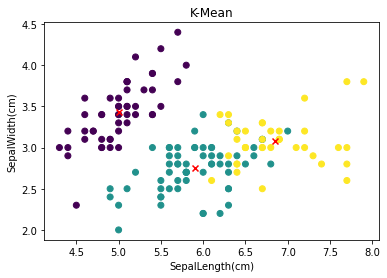

In [9]:
#起始時間
start = datetime.datetime.now()
#訓練
Kclustering= KMeans(n_clusters = 3).fit(iris.data)
#結束時間
end = datetime.datetime.now()
#機器自動分群並預測結果
print(Kclustering.labels_)
#散佈圖
plt.title('K-Mean')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
plt.scatter(iris.data[:,0],iris.data[:,1],c=Kclustering.labels_)
#中心點
centers = Kclustering.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red' ,marker='x');
#輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Kclustering.labels_))

In [21]:
np.concatenate((np.unique(iris.target), [np.max(np.unique(iris.target))+1]), axis=0)

array([0, 1, 2, 3])

In [23]:
    # matrix which will hold the majority-voted labels
    #生成一個真實標籤大小的矩陣，且個數皆為0
    y_voted_labels = np.zeros(iris.target.shape) #e.g. array([0., 0., 0.,..., 0., 0.])
    
    # 排序標籤 Ordering labels
    ## 標籤可能會遺失，像是某集合(0,2)，其中缺少1。Labels might be missing e.g with set like 0,2 where 1 is missing
    ## 首先找到唯一標籤，然後將標籤變成有順序的集合。First find the unique labels, then map the labels to an ordered set
    ## 0,2就會變成0,1。0,2 should become 0,1
    
    #讀取標籤類別個數 
    labels = np.unique(iris.target) #e.g. array([0, 1, 2])
    
    ordered_labels = np.arange(labels.shape[0]) #e.g. array([0, 1, 2])
    #將資料集y的類別放進ordered_labels
    for k in range(labels.shape[0]):
        iris.target[iris.target==labels[k]] = ordered_labels[k]
        
    # 更新標籤。Update unique labels
    labels = np.unique(iris.target)
    # 我們將bins的數量設定為n_classes+2。We set the number of bins to be n_classes+2 so that 
    # 我們計算兩個連續bins之間類別的實際發生次數。we count the actual occurence of classes between two consecutive bins
    # 較大的會被排除掉。the bigger being excluded [bin_i, bin_i+1]
    bins = np.concatenate((labels, [np.max(labels)+1]), axis=0) #e.g. array([0, 1, 2, 3])

    
    for cluster in np.unique(Kclustering.labels_):
        hist, _ = np.histogram(iris.target[Kclustering.labels_==cluster], bins=bins)
        # 找群中最常見的標籤。Find the most present label in the cluster
        winner = np.argmax(hist)
        y_voted_labels[Kclustering.labels_==cluster] = winner

accuracy_score(iris.target, y_voted_labels)

0.8933333333333333

# Hierarchical Clustering

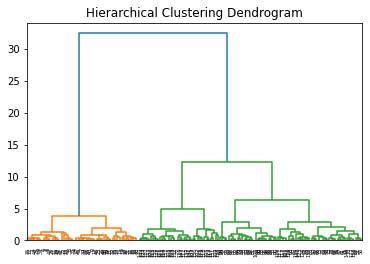

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 2 2 2 2 3 2 2 2 2
 2 2 3 3 2 2 2 2 3 2 3 2 3 2 2 3 3 2 2 2 2 2 3 3 2 2 2 3 2 2 2 3 2 2 2 3 2
 2 3]
執行時間： 0:00:02.298858
Purity: 0.8933333333333333


In [115]:
#起始時間
start = datetime.datetime.now()
dis=sch.linkage(iris.data,metric='euclidean',method='ward')
sch.dendrogram(dis)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()
Hclustering=sch.fcluster(dis,3,criterion='maxclust')
print(Hclustering)
#結束時間
end = datetime.datetime.now()
# 輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Hclustering))

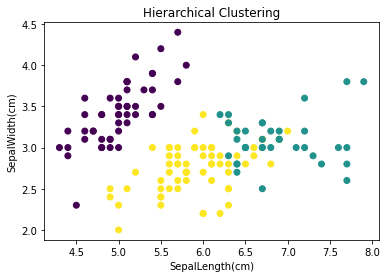

In [116]:
#散佈圖
plt.title('Hierarchical Clustering')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
plt.scatter(iris.data[:,0],iris.data[:,1],c=Hclustering)

# DBSCAN

In [112]:
#起始時間
start = datetime.datetime.now()
#訓練
Dclustering=DBSCAN(eps=0.4,min_samples=4).fit(iris.data)
#機器自動分群並預測結果
print(Dclustering.labels_)
#結束時間
end = datetime.datetime.now()
# 輸出程式花費時間
print("執行時間：", end - start)
#輸出Purity指標
print("Purity:",purity_score(iris.target, Dclustering.labels_))

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0  0 -1  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 -1  0  0  0  0  0  0
  0  0  1  1  1  1  1  1  1  3  1  1  3  1 -1  1 -1  1  1  1 -1  1  2  1
  2  1  1  1  1  1  1  1  1  1  1  2  1 -1  1 -1  1  1  1  1  1  3  1  1
  1  1  3  1 -1  2  2  2  2 -1 -1 -1 -1 -1  2  2  2  2 -1  2  2 -1 -1 -1
  2  2 -1  2  2 -1  2  2  2 -1 -1 -1  2  2 -1 -1  2  2  2  2  2  2  2  2
  2  2  2  2  2  2]
執行時間： 0:00:00.003989
Purity: 0.9266666666666666


# 選擇DBSCAN最佳參數

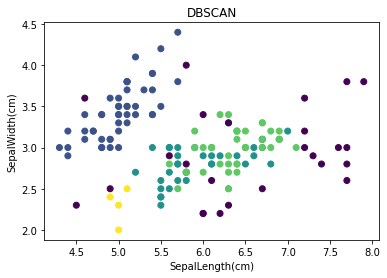

In [113]:
#散佈圖
plt.title('DBSCAN')
plt.xlabel('SepalLength(cm)')
plt.ylabel('SepalWidth(cm)')
plt.scatter(iris.data[:,0],iris.data[:,1],c=Dclustering.labels_)